# 0. Install dependecies and Bring Data

In [1]:
!pip install tensorflow-gpu pandas matplotlib sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv('/content/jigsaw-toxic-comment-classification-challenge/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
df.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [14]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# 2. Preprocess

In [27]:
from tensorflow.keras.layers import TextVectorization

In [28]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [29]:
MAX_FEATURES = 200000 #number of words in the vocab

In [37]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [38]:
vectorizer.adapt(X.values)

In [39]:
vectorizer("hello world, life is great")

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([288, 263, 306, ...,   0,   0,   0])>

In [40]:
vectorized_text = vectorizer(X.values)

In [41]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [42]:
# MCSHBAP - map, chache, shuffle, batch, prefetch from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [51]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [53]:
batch_X.shape

(16, 1800)

In [54]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [55]:
train_generator = train.as_numpy_iterator()

# 2. Create Sequential Model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [59]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# final layer for output
model.add(Dense(6, activation='sigmoid'))

In [60]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [62]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 13154s 2s/step - loss: 0.0625 - val_loss: 0.0449


In [64]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

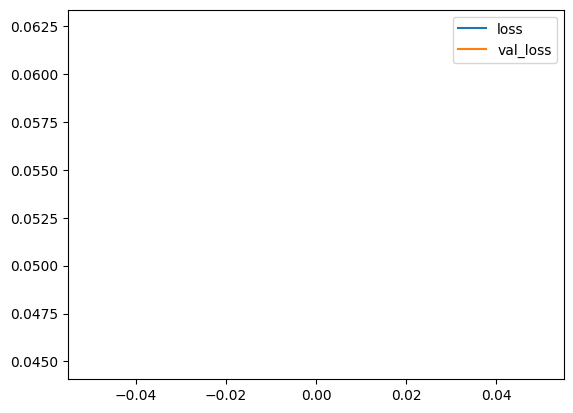

In [65]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Making prediction

In [66]:
input_text = vectorizer("you freaking suck !")

In [67]:
batch = test.as_numpy_iterator().next()

In [68]:
model.predict(np.array([input_text]))

1/1 [==============================] - 1s 1s/step


array([[0.9862694 , 0.28331462, 0.8933112 , 0.10427531, 0.7679801 ,
        0.1836041 ]], dtype=float32)

In [69]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 159ms/step


# 4. Evaluate the model

In [71]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [72]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [73]:
for batch in test.as_numpy_iterator():
    # unpack the batch
    X_true, y_true = batch
    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 218ms/step


In [75]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision: 0.8604738712310791, Recall:0.6355555653572083,Accuracy:0.46439316868782043


# 4. Test and Gradio

In [76]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.4/312.4 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=

In [77]:
import gradio as gr

In [78]:
model.save('toxicity.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
model = tf.keras.models.load_model('/content/toxicity.h5')
input_str = vectorizer('Hey I hate you')
res = model.predict(np.expand_dims(input_str,0))
res

1/1 [==============================] - 1s 1s/step


array([[0.991739  , 0.34211352, 0.9182126 , 0.10820577, 0.7986698 ,
        0.19112237]], dtype=float32)

In [90]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}:\n'.format(col, results[0][idx]>0.5)
    return text

In [91]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder="Comment to score"),
                         outputs='text')

In [92]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9dcbd07d5e3c66f902.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
